In [245]:
from math import ceil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import re
import nltk
from unidecode import unidecode
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import cluster
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from wordcloud import WordCloud

## use display for html output
from IPython.display import display, HTML

# auto-reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
plt.style.use('dark_background')

In [46]:
# some nltk word lists
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [19]:
raw_df = pd.read_csv('./anthems.csv')
raw_df.columns = map(str.lower, raw_df.columns)
raw_df.head()

,country,alpha-2,alpha-3,continent,anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


Here: Alpha-2 & Alpha-3 represent the different coutries ISO codes.


### Preprocessing


Outline of preprocessing:
1. **Corpus tokenization**, that is, divide the different texts into individual words.
2. **Stop words removal,** which are common words (a, the, not, etc) that bring close to no contribution to the semantic meaning of a text
3. **Noise removal** from the texts, that means basically anything that can’t be recongnized as a english word, such as words with non ASCII symbols, words together with numbers, etc.
4. **Stemming,** which reduces a word to it’s root. Ie: [consultant, consulting, consultants] -> consult

In [20]:
corpus = raw_df['anthem'].tolist()
corpus[0]


'Around our flag we stand united, With one wish and one goal, A sacred oath we bestow upon it Proclaiming loyalty for our salvation. From war abstains only he, Who a traitor is born, He who is a true man is not frightened, But dies a warrior to the cause. With weapons in our hands a-brandished, We will defend our fatherland, Our sacred rights weÃ¢â‚¬â„¢ll not relinquish, The foe has no place in our land. For God himself proclaimed The nations of the earth shall wane, And yet will live, will thrive Albania. For you, for you we fight. O Flag, flag, you sacred symbol Upon you we now swear For Albania, our dear fatherland For honour and your glory. Brave man is named and honoured The one who sacrificed himself for the fatherland Forever he will be remembered On earth and under as a saint!'

In [50]:
def load_words(file_name: str)->list[str]:
    with open(file_name, 'r') as f:
        return f.read().splitlines()

def remove_words(words: list[str], remove_list: list[str]) -> list[str]:
    return [word for word in words if word not in remove_list]


def applyStemming(listOfTokens: list[str], stemmer: nltk.stem.snowball.SnowballStemmer) -> list[str]:
    return [stemmer.stem(token) for token in listOfTokens]

def remove_words_less_max_length(words: list[str], max_length: int) -> list[str]:
    is_valid_length = lambda length : 2 <= length <= max_length
    return [word for word in words if is_valid_length(len(word))]


def remove_undefined_chars_from_anthem(anthem: str) -> str:
            
    anthem = anthem.replace(u'\ufffd', '8')   # Replaces the ASCII '�' symbol with '8'
    anthem = anthem.replace(',', '')          # Removes commas
    anthem = anthem.rstrip('\n')              # Removes line breaks
    anthem = anthem.casefold()                # Makes all letters lowercase
    
    anthem = re.sub('\W_',' ', anthem)        # removes specials characters and leaves only words
    anthem = re.sub("\S*\d\S*"," ", anthem)   # removes numbers and words concatenated with numbers IE h4ck3r. Removes road names such as BR-381.
    anthem = re.sub("\S*@\S*\s?"," ", anthem) # removes emails and mentions (words with @)
    anthem = re.sub(r'http\S+', '', anthem)   # removes URLs with http
    anthem = re.sub(r'www\S+', '', anthem)    # removes URLs with www

    return anthem

def remove_noise(anthem: str) -> list[str]:

    stop_words = nltk.corpus.stopwords.words(language)
    country_names = load_words('./word_lists/country_names.txt')
    nationalities = load_words('./word_lists/nationalities.txt')
    
    anthem = remove_undefined_chars_from_anthem(anthem)

    words = nltk.tokenize.word_tokenize(anthem)
    words = remove_words(words, stop_words)
    words = remove_words(words, country_names)
    words = remove_words(words, nationalities)
    words = remove_words_less_max_length(words, 21)

    return words


In [51]:
language = 'english'

stemmer = nltk.stem.SnowballStemmer(language)
excess_stop_words = load_words('./word_lists/stop_words.txt')

for idx, anthem in enumerate(corpus):
    anthem = remove_noise(anthem)
    anthem = applyStemming(anthem, stemmer)
    anthem = remove_words(anthem, excess_stop_words)

    corpus[idx] =unidecode(" ".join(anthem))

In [52]:
corpus[1]

'fatherland free independ centuri live summon son free independ flag brother sewn hand sleepless night bath tear tricolor valuabl symbol shine enemi glorious forev death everywh man die bless die freedom nation'

#### Statistical Weighting of Words
Now we will apply the TF-IDF function, short for term frequency inverse document frequency, which is a numerical statistic that's intended to reflect how important a word is to a document in a corpus by giving each word in a document a score that ranges from 0 to 1.

In [54]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
tf_idf = pd.DataFrame(data=X.toarray(), columns=vectorizer.get_feature_names())

final_df = tf_idf

print("{} rows".format(final_df.shape[0]))
final_df.T.nlargest(5, 0)


190 rows


e:\Sarath\ML-AI-DataScience\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0,1,2,3,4,5,6,7,8,9,...,180,181,182,183,184,185,186,187,188,189
independ,0.304047,0.304047,0.0,0.000000,0.089419,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
die,0.263090,0.263090,0.0,0.134847,0.000000,0.0,0.0,0.090911,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.161245,0.0,0.0,0.0,0.0
sewn,0.251374,0.251374,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
sleepless,0.251374,0.251374,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
summon,0.251374,0.251374,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


### K-Means Clustering

In [60]:
def run_KMeans(max_k: int, data: pd.DataFrame) -> dict:
    max_k += 1
    kmeans_results = dict()
    for k in range(2, max_k):
        kmeans = cluster.KMeans(n_clusters=k, init='k-means++', n_init=10,
                                tol=0.0001, random_state=1, algorithm='full')

        kmeans_results.update({k: kmeans.fit(data)})

    return kmeans_results


#### Elbow Method

In [203]:
def plot_elbow(kmeans_results):
    wcss = [kmeans.inertia_ for kmeans in kmeans_results.values()]
    plt.plot(range(1, len(wcss)+1), wcss)
    plt.title('The Elbow graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('Average distance to centroids')


#### Sihouette Score

In [191]:
def printAvg(avg_dict):
    for avg in sorted(avg_dict.keys(), reverse=True):
        print("Avg: {}\tK:{}".format(avg.round(4), avg_dict[avg]))


def plotSilhouette(df, nth_cluster, kmeans_labels, silhouette_avg, ax1):
    ax1.set_xlim([-0.2, 1])
    ax1.set_ylim([0, len(df) + (nth_cluster + 1) * 10])
    ax1.axvline(x=silhouette_avg, color="#bceeff", linestyle="--") # The vertical line for average silhouette score of all the values
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
    ax1.set_title(f"Silhouette analysis for K = {nth_cluster}",fontsize=16, fontweight='bold')
    
    y_lower = 10
    sample_silhouette_values = silhouette_samples(df, kmeans_labels) # Compute the silhouette scores for each sample
    for i in range(nth_cluster):
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / nth_cluster)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i)) # Label the silhouette plots with their cluster numbers at the middle
        y_lower = y_upper + 10  # Compute the new y_lower for next plot. 10 for the 0 samples
    
        
def silhouette(kmeans_dict, df, plot=False):
    avg_dict = dict()
    cols = 3
    rows = ceil(len(kmeans_dict) / cols)
    fig, axs = plt.subplots(rows, cols, figsize=(32, 10*rows))
    for idx, (num_cluster, kmeans) in enumerate(kmeans_dict.items()):
        kmeans_labels = kmeans.predict(df)
        silhouette_avg = silhouette_score(df, kmeans_labels) # Average Score for all Samples
        avg_dict.update( {silhouette_avg : num_cluster} )
        
        if(plot): 
            # plt.subplot(5, 6, idx+1)
            plotSilhouette(df, num_cluster, kmeans_labels, silhouette_avg, axs[idx//cols, idx%cols])

In [230]:
# Running Kmeans
k = 20
kmeans_results = run_KMeans(k, final_df)

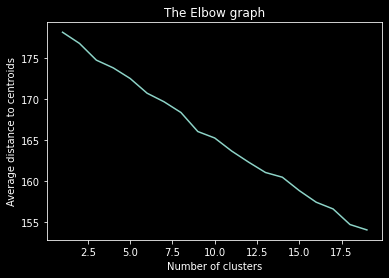

In [231]:
plot_elbow(kmeans_results)

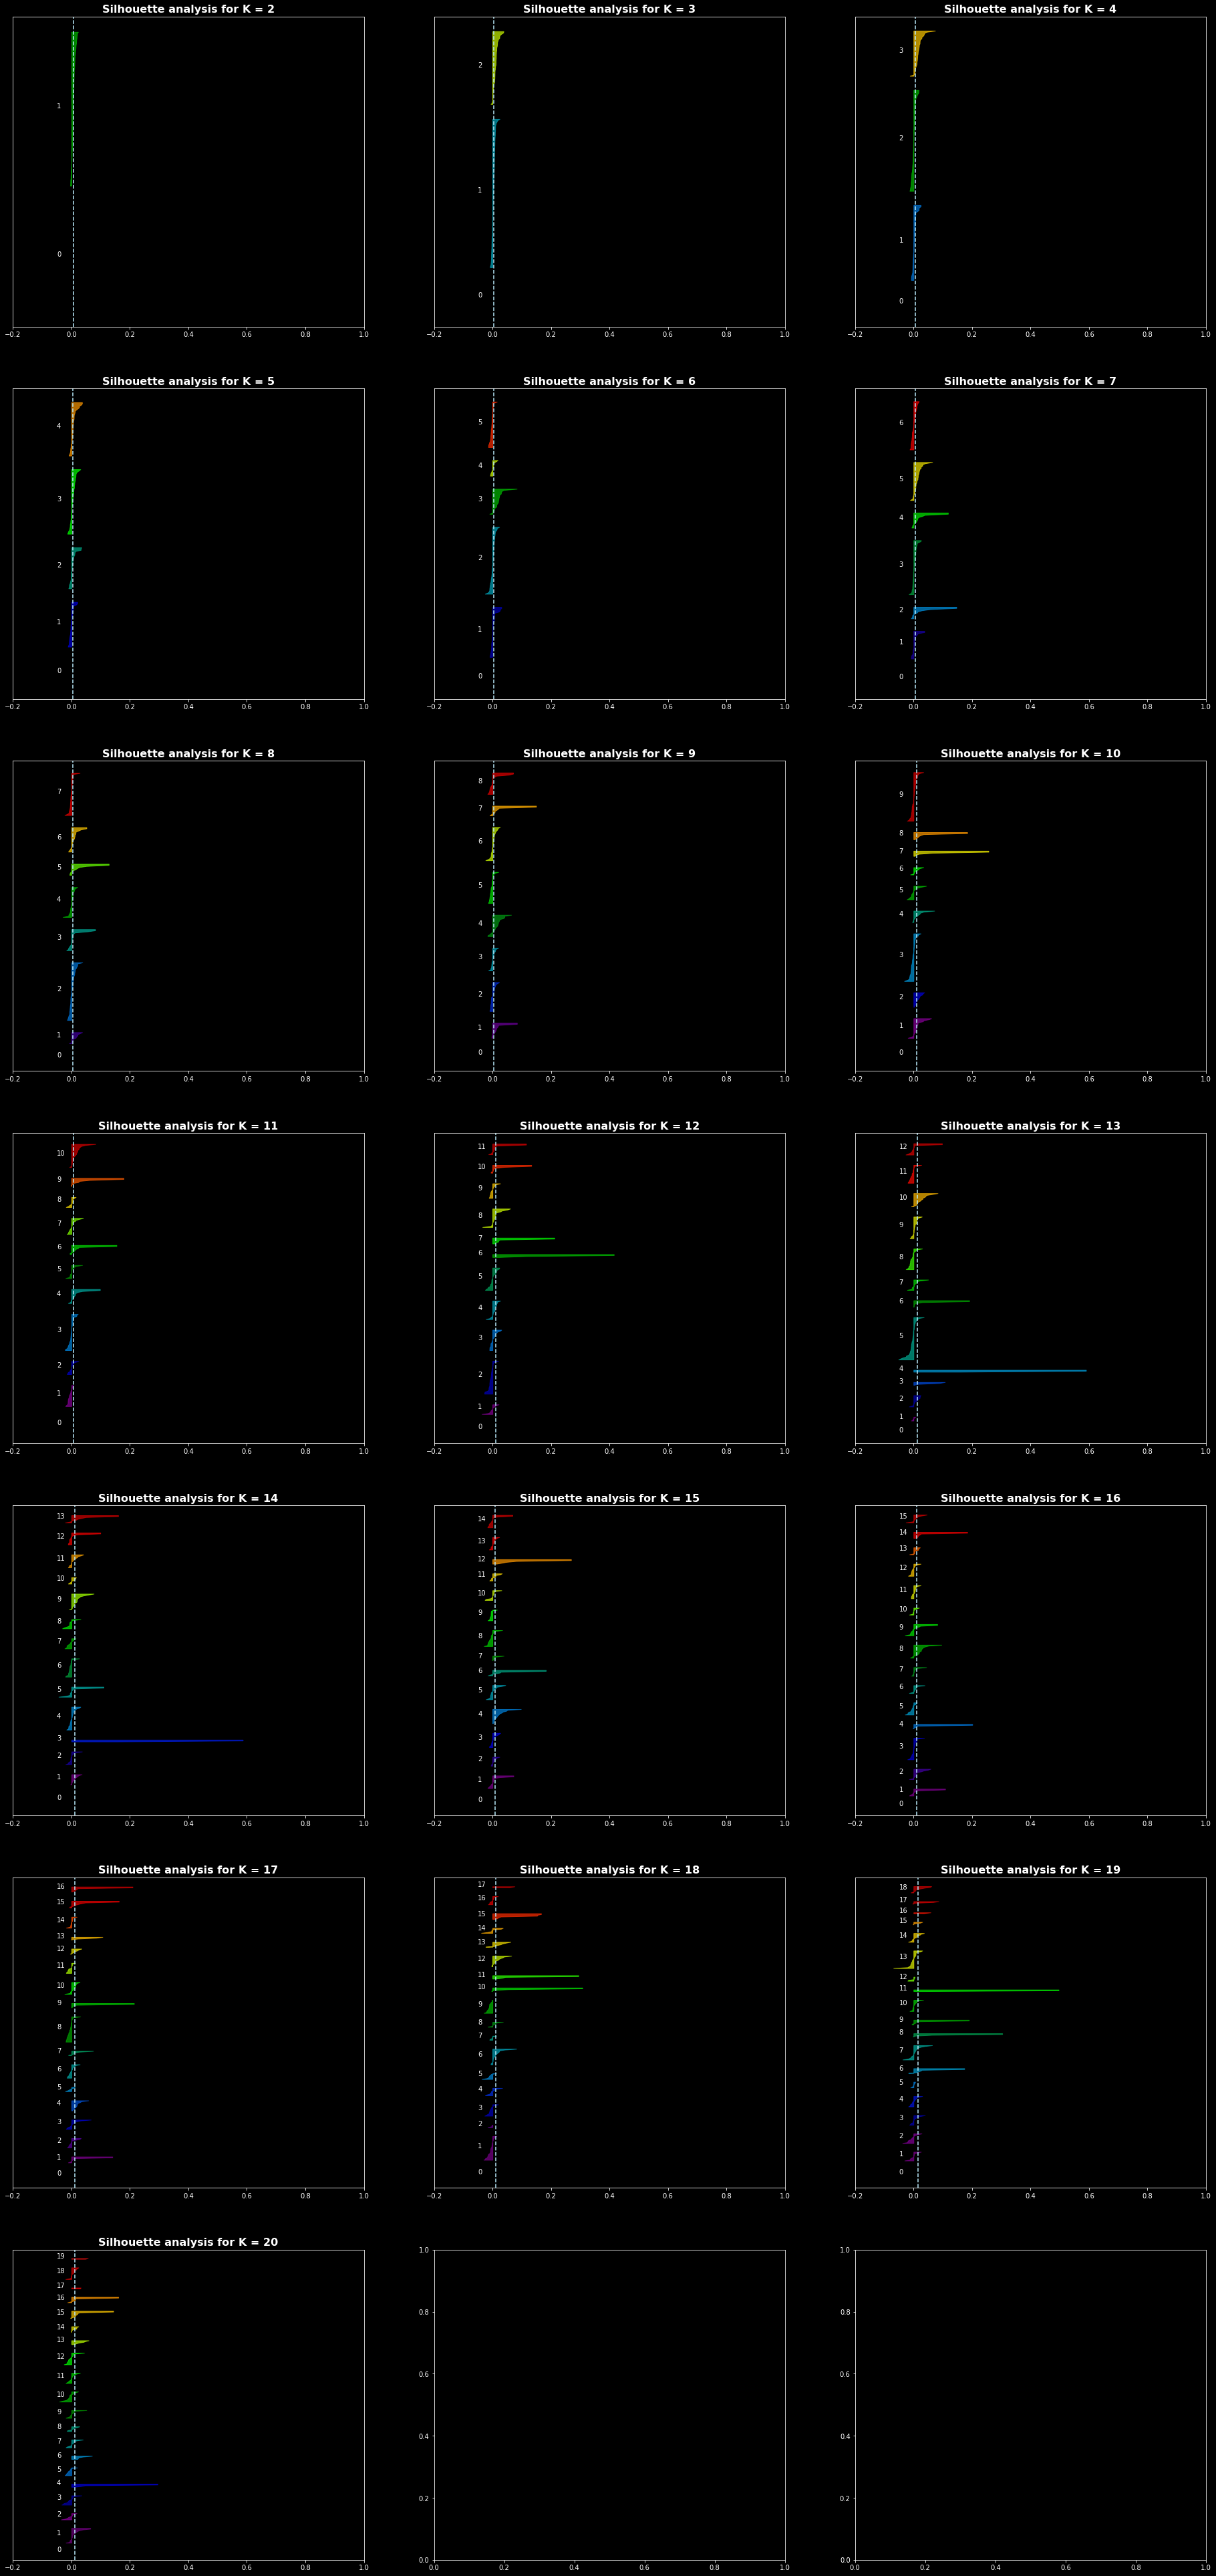

In [232]:
# Plotting Silhouette Analysis
silhouette(kmeans_results, final_df, plot=True)

Looking at the plots above, we have some clues that when K = 5 is when the clusters are best defined. So first we will use a simple histogram to look at the most dominant words in each cluster:

In [241]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction == label)  # indices for each cluster
        # returns average score across cluster
        x_means = np.mean(tf_idf_array.iloc[id_temp], axis=0)
        # indices with top 20 scores
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns=['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    no_cols = 2
    no_rows = ceil(len(dfs) / no_cols)
    fig, axs = plt.subplots(no_rows, no_cols, figsize=(32, 10*no_rows))
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        ax = axs[i//no_cols, i%no_cols]
        ax.set_title((f"Most Common Words in Cluster {i}"),
                  fontsize=14, fontweight='bold')
        sns.barplot(x='score', y='features', orient='h', data=dfs[i][:n_feats], ax=axs[i//no_cols, i%no_cols], palette="crest")



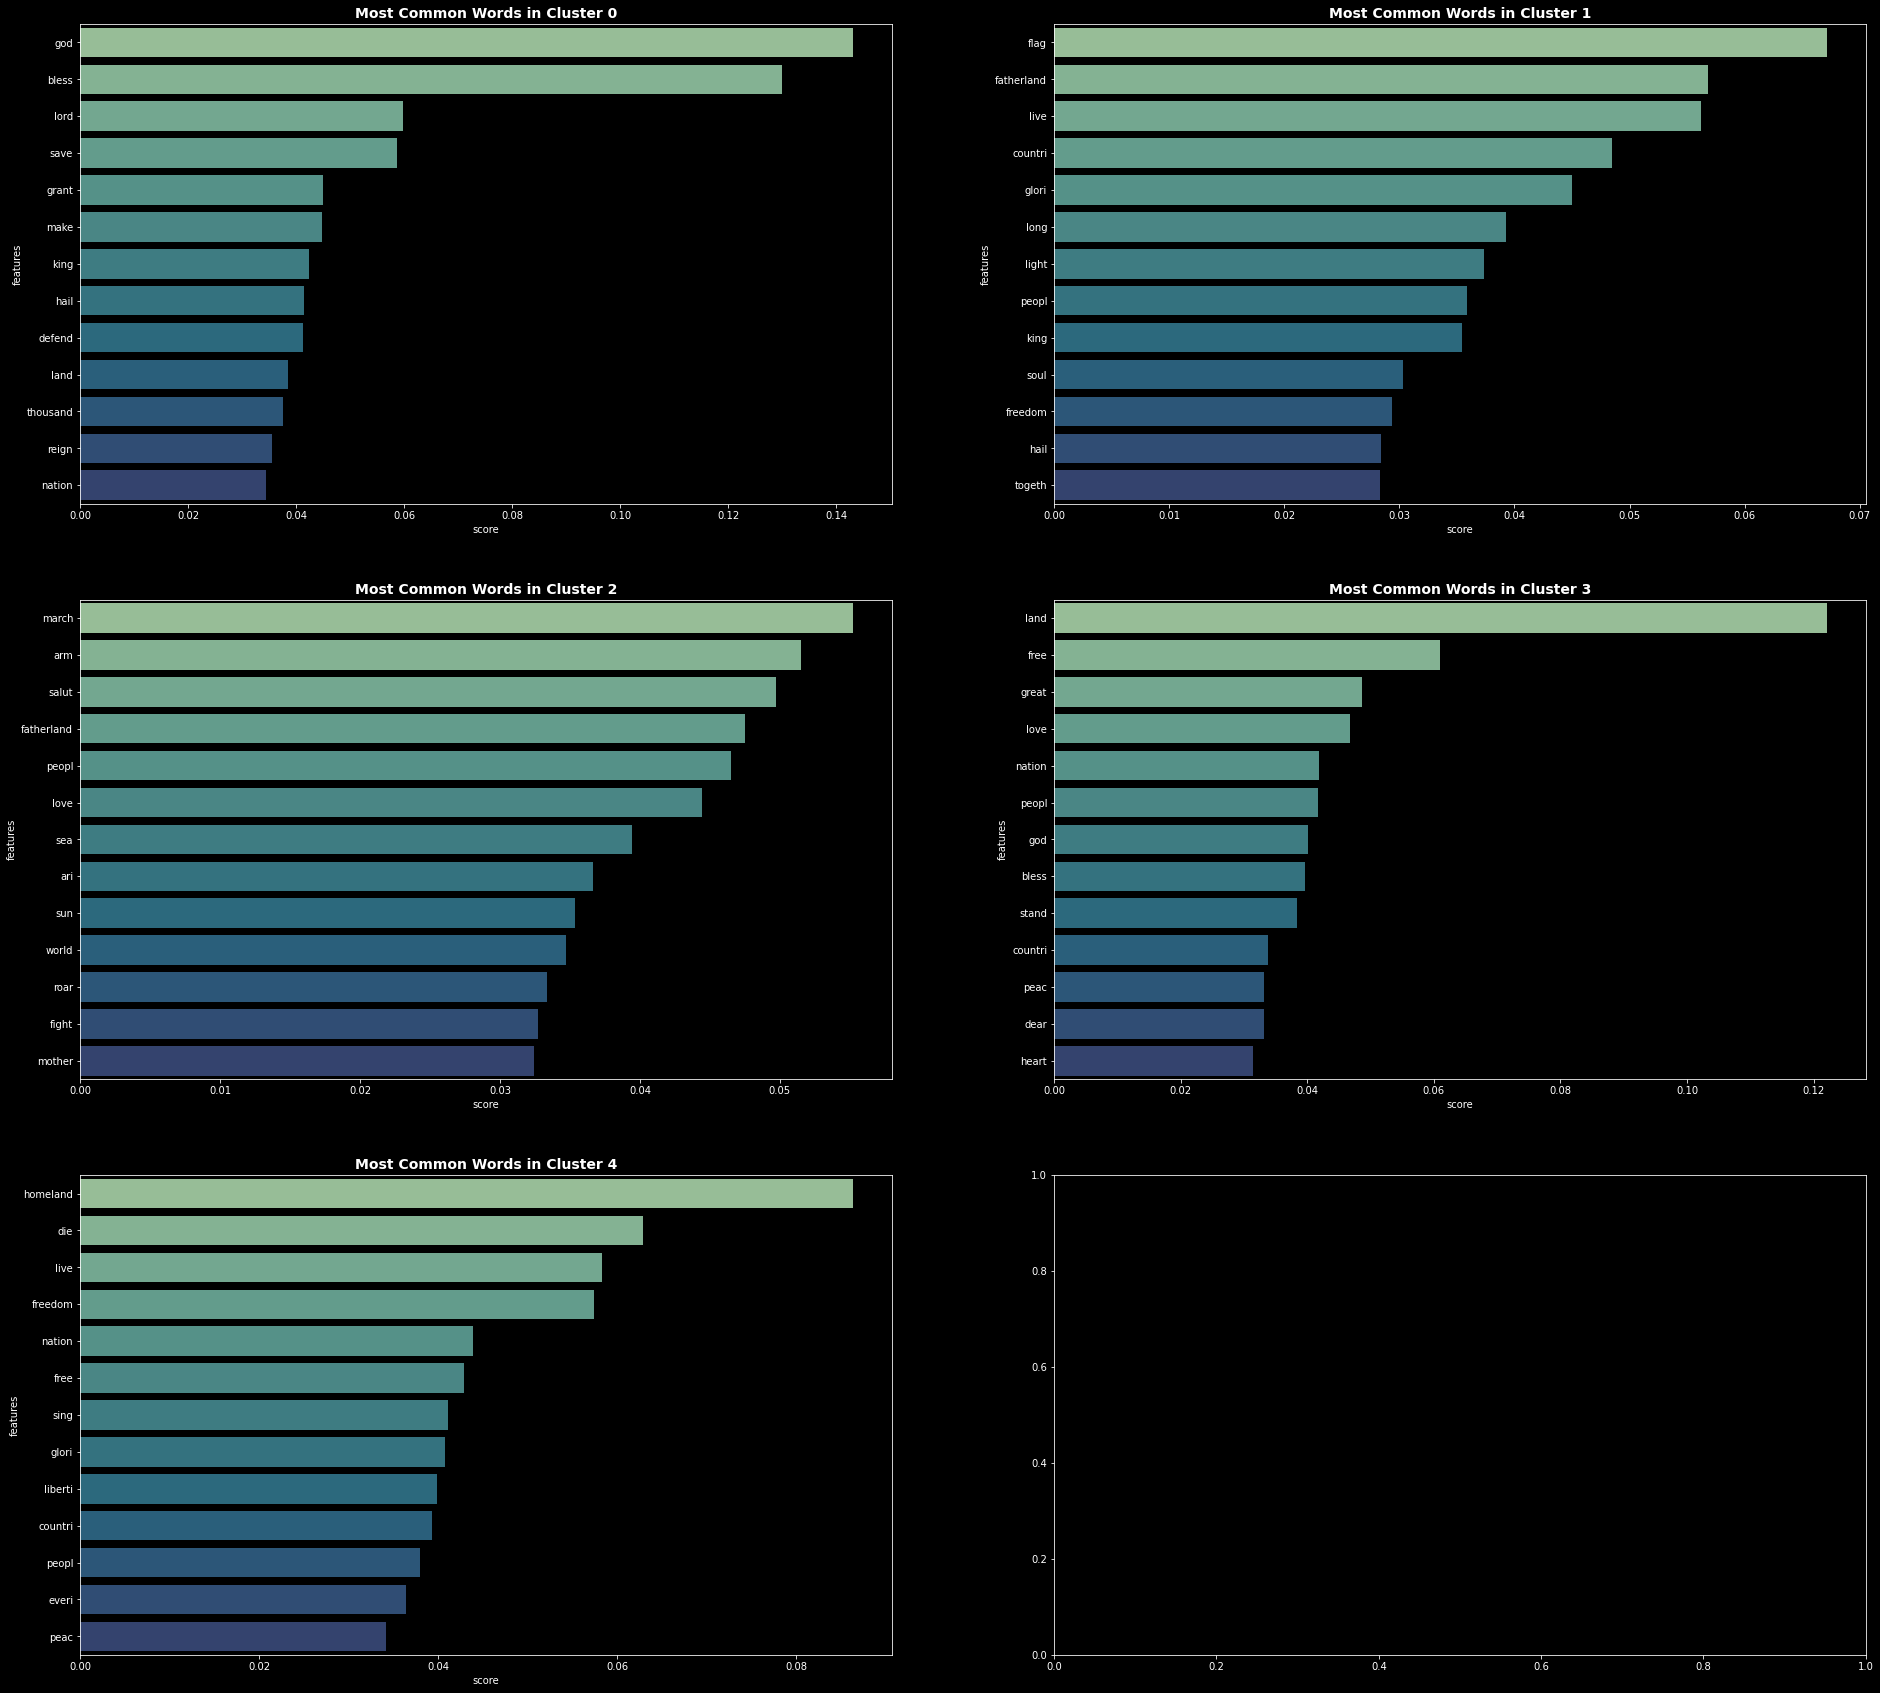

<Figure size 576x288 with 0 Axes>

In [242]:
best_result = 5
kmeans = kmeans_results.get(best_result)

# final_df_array = final_df.to_numpy()
prediction = kmeans.predict(final_df)
n_feats = 20
dfs = get_top_features_cluster(final_df, prediction, n_feats)
plotWords(dfs, 13)


In [273]:
# Transforms a centroids dataframe into a dictionary to be used on a WordCloud.
def centroidsDict(centroids, index):
    a = centroids.T[index].sort_values(ascending=False).reset_index().values
    centroid_dict = dict()

    for i in range(0, len(a)):
        centroid_dict.update({a[i, 0]: a[i, 1]})

    return centroid_dict


def generateWordClouds(centroids):
    no_cols = 3
    no_rows = ceil(len(centroids) / no_cols)
    fig, axs = plt.subplots(no_rows, no_cols, figsize=(32, 10*no_rows))
    wordcloud = WordCloud(max_font_size=100, background_color='white')
    for i in range(0, len(centroids)):
        centroid_dict = centroidsDict(centroids, i)
        wordcloud.generate_from_frequencies(centroid_dict)
        
        ax = axs[i//no_cols, i%no_cols]
        ax.set_title('Cluster {}'.format(i))
        ax.imshow(wordcloud)
        ax.axis("off")



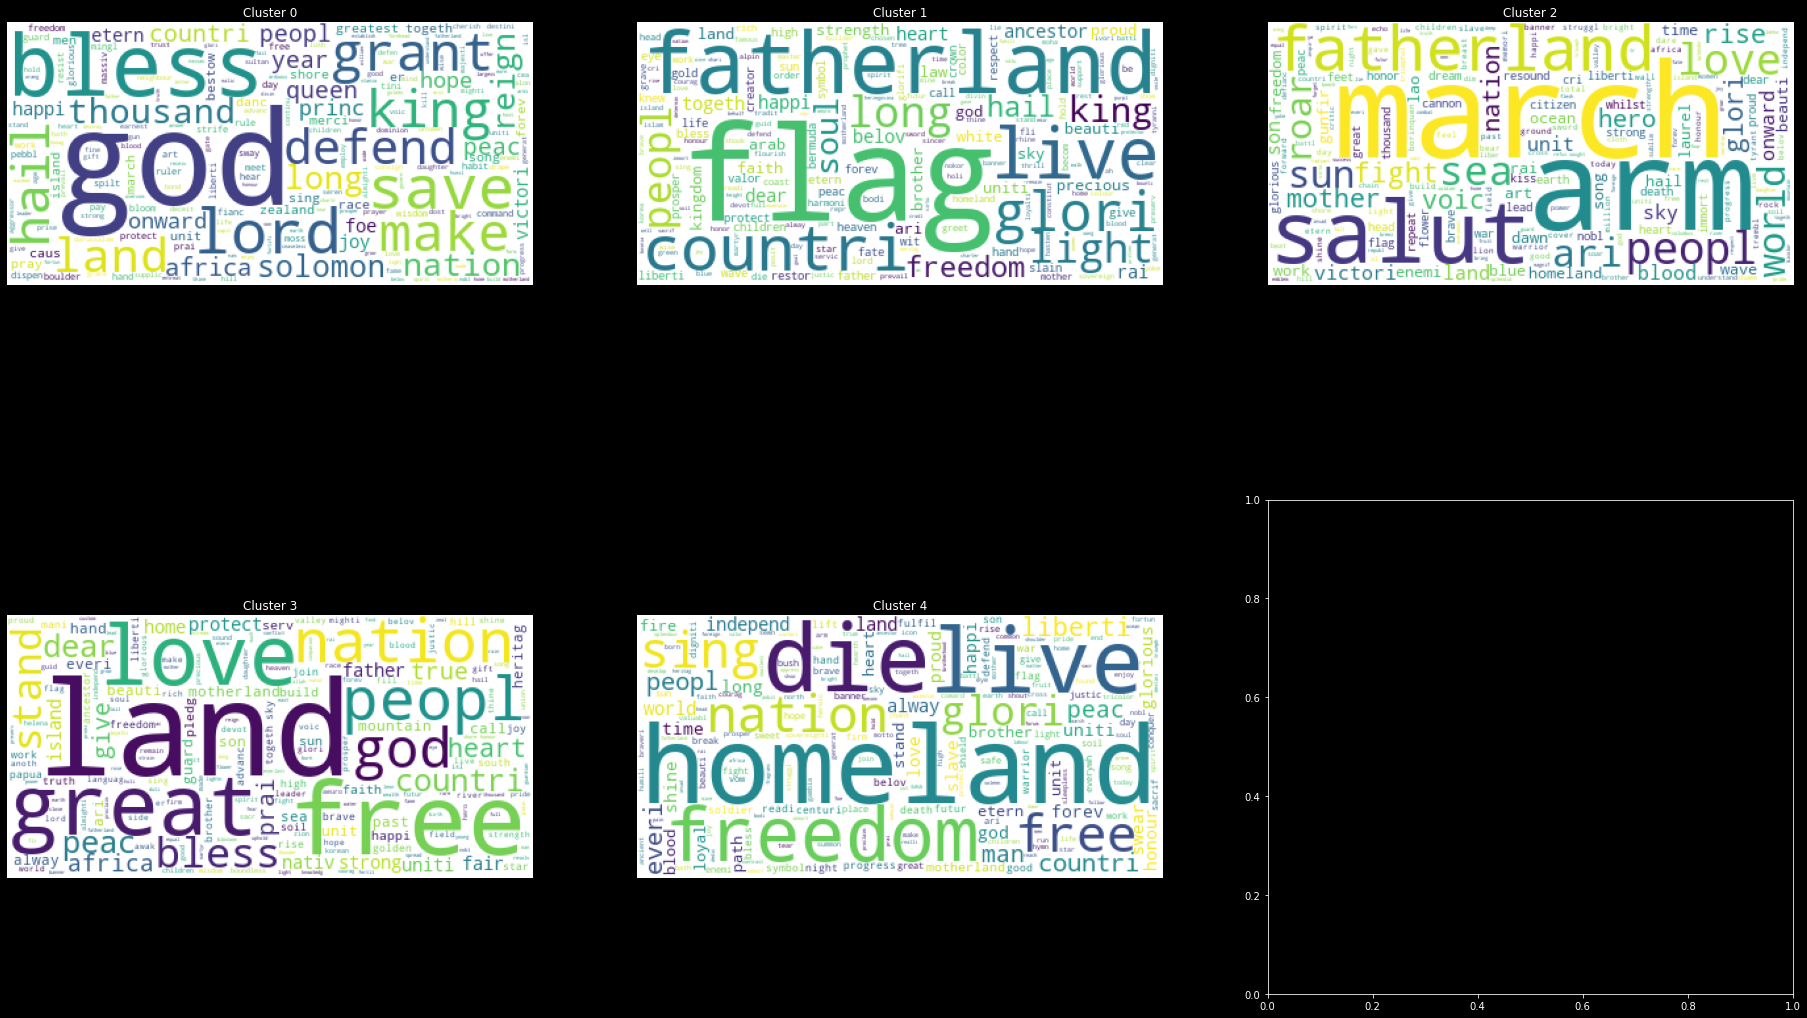

In [274]:
centroids = pd.DataFrame(kmeans.cluster_centers_)
centroids.columns = final_df.columns
generateWordClouds(centroids)


In [256]:
raw_df.head()

,country,alpha-2,alpha-3,continent,anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


In [257]:
data = raw_df.copy()
# Assigning the cluster labels to each country
labels = kmeans.labels_
data['label'] = labels
data.head()


,country,alpha-2,alpha-3,continent,anthem,label
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",4
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",4
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",3
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",1
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",1


In [261]:
# Map Viz
import json
import geopandas as gpd

# Loading countries polygons
geo_path = 'world-countries.json'
country_geo = json.load(open(geo_path))
gpf = gpd.read_file(geo_path)

# Merging on the alpha-3 country codes
merge = pd.merge(gpf, data, left_on='id', right_on='alpha-3')
data_to_plot = merge[["id", "name", "label", "geometry"]]

data_to_plot.head(3)


,id,name,label,geometry
0,AFG,Afghanistan,3,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,2,"MULTIPOLYGON (((16.32653 -5.87747, 16.57318 -6..."
2,ALB,Albania,4,"POLYGON ((20.59025 41.85540, 20.46317 41.51509..."


In [265]:
import branca.colormap as cm

# Creating a discrete color map
values = data_to_plot[['label']].to_numpy()
color_step = cm.StepColormap(
    ['r', 'y', 'g', 'b', 'm'], vmin=values.min(), vmax=values.max(), caption='step')

color_step


In [263]:
import folium
from branca.element import Figure


def make_geojson_choropleth(display, data, colors):
    '''creates geojson choropleth map using a colormap, with tooltip for country names and groups'''
    group_dict = data.set_index(
        'id')['label']  # Dictionary of Countries IDs and Clusters
    tooltip = folium.features.GeoJsonTooltip(
        ["name", "label"], aliases=display, labels=True)
    return folium.GeoJson(data[["id", "name", "label", "geometry"]],
                          style_function=lambda feature: {
        'fillColor': colors(group_dict[feature['properties']['id']]),
        #'fillColor': test(feature),
        'color': 'black',
        'weight': 0.5
    },
        highlight_function=lambda x: {'weight': 2, 'color': 'black'},
        smooth_factor=2.0,
        tooltip=tooltip)

# Makes map appear inline on notebook


def display(m, width, height):
    """Takes a folium instance and embed HTML."""
    fig = Figure(width=width, height=height)
    fig.add_child(m)
    #return fig


In [279]:
# Initializing our Folium Map
m = folium.Map(location=[43.5775, -10.106111], zoom_start=2.3, tiles='cartodbpositron')

# Making a choropleth map with geojson
geojson_choropleth = make_geojson_choropleth(["Country:", "Group:"], data_to_plot, color_step)
geojson_choropleth.add_to(m)

width, height = 1300, 675
display(m, width, height)
m